In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from scipy.io import loadmat

In [2]:
subject = 3

In [3]:
'''
read_raw_filename = 'data/B0101T.gdf'
save_epo_filename = 'data/B0101T_epo.fif'

raw = mne.io.read_raw_gdf(read_raw_filename, preload=True)

raw.drop_channels(['EOG:ch01','EOG:ch02','EOG:ch03'])

# 768 --- start a trial
custom_mapping = {'769':3,'770':4}
(events_from_annot,event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
#  3s开始为时间cue
raw_epochs = mne.Epochs(raw, events=events_from_annot, event_id=event_dict,proj=True,baseline=(None, 0), preload=True,tmin=-2,tmax=6)

evoked = raw_epochs.average()
evoked.plot(time_unit='s')

raw_epochs.save(save_epo_filename)
'''

"\nread_raw_filename = 'data/B0101T.gdf'\nsave_epo_filename = 'data/B0101T_epo.fif'\n\nraw = mne.io.read_raw_gdf(read_raw_filename, preload=True)\n\nraw.drop_channels(['EOG:ch01','EOG:ch02','EOG:ch03'])\n\n# 768 --- start a trial\ncustom_mapping = {'769':3,'770':4}\n(events_from_annot,event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)\n#  3s开始为时间cue\nraw_epochs = mne.Epochs(raw, events=events_from_annot, event_id=event_dict,proj=True,baseline=(None, 0), preload=True,tmin=-2,tmax=6)\n\nevoked = raw_epochs.average()\nevoked.plot(time_unit='s')\n\nraw_epochs.save(save_epo_filename)\n"

训练集数据读取，tfr

In [4]:
#时频图分析设置
#截取的数据段为2s-7s的数据
tmin = 2
tmax = 7

freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [2, 3]  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

In [5]:
i=0

In [6]:
filename = 'data/B0' + str(subject) + '0'+ str( i + 1) +'T_epo.fif'
epochs = mne.read_epochs(filename)

Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\data\B0301T_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


In [7]:
all_epoch_num = 400   #训练集共400个epoch
all_test_epoch_num = 320   # 共320个epoch

In [8]:
# trials * [(c3+c4)*freq] * timepoints 
TF_PIC = np.zeros((all_epoch_num,68,626))  

epo_cnt = 0

for i in range(3):
    filename = 'data/B0' + str(subject) + '0'+ str( i + 1) +'T_epo.fif'
    epochs = mne.read_epochs(filename)

    #时频分析
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

    df = tfr.to_data_frame(time_format=None)

    for epo in range(len(epochs)):
        epoch_0 = df.loc[df['epoch'] == epo]
        C3= epoch_0['EEG:C3']
        C4= epoch_0['EEG:C4']
        data = np.concatenate((C3.values.reshape(34,-1),C4.values.reshape(34,-1)))
        
        
        TF_PIC[epo_cnt,:,:] = data
        epo_cnt += 1

Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\data\B0301T_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Applying baseline correction (mode: percent)
Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\data\B0302T_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Applying baseline correction (mode: percent)
Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\data\B0303T_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    7000.00 ms
        0 CTF compensation m

读取训练集标签

In [9]:
train_label_r = np.zeros((all_epoch_num,1))

cnt = 0
for i in range(3):
    filename = 'data/B0' + str(subject) + '0'+ str( i + 1) +'T.mat'
    raw_label_data = loadmat(filename)
    print( raw_label_data['classlabel'].shape)
    train_label_r[cnt:cnt+len(raw_label_data['classlabel']),:] = raw_label_data['classlabel'] - 1 
    cnt += len(raw_label_data['classlabel'])
    print(cnt)
    

(120, 1)
120
(120, 1)
240
(160, 1)
400


In [10]:
train_label_raw = np.zeros((all_epoch_num,2))

for i in range(all_epoch_num):
    if(train_label_r[i]==0):
        train_label_raw[i,0] = 1
    else:
        train_label_raw[i,1] = 1

In [11]:
train_label_raw[0:10,:]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

读取测试集数据

In [12]:
# trials * [(c3+c4)*freq] * timepoints 
TF_TEST_PIC = np.zeros((all_test_epoch_num,68,626))  

epo_cnt = 0

for i in range(2):
    filename = 'data/B0' + str(subject) + '0'+ str( i + 4) +'E_epo.fif'
    epochs = mne.read_epochs(filename)

    #时频分析
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

    df = tfr.to_data_frame(time_format=None)

    for epo in range(len(epochs)):
        epoch_0 = df.loc[df['epoch'] == epo]
        C3= epoch_0['EEG:C3']
        C4= epoch_0['EEG:C4']
        data = np.concatenate((C3.values.reshape(34,-1),C4.values.reshape(34,-1)))
        
        
        TF_TEST_PIC[epo_cnt,:,:] = data
        epo_cnt += 1

Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\data\B0304E_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Applying baseline correction (mode: percent)
Reading e:\19_BCIexperiment\02_CodeTest\MNE_TEST\data\B0305E_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Applying baseline correction (mode: percent)


In [13]:
epo_cnt

320

读取测试集标签

In [14]:
test_label_r = np.zeros((all_test_epoch_num,1))

cnt = 0
for i in range(2):
    filename = 'data/B0' + str(subject) + '0'+ str(i+4) +'E.mat'
    raw_label_data = loadmat(filename)
    print( raw_label_data['classlabel'].shape)
    test_label_r[cnt:cnt+len(raw_label_data['classlabel']),:] = raw_label_data['classlabel'] - 1
    cnt += len(raw_label_data['classlabel'])
    print(cnt)

(160, 1)
160
(160, 1)
320


In [15]:
test_label_raw = np.zeros((all_test_epoch_num,2))

for i in range(all_test_epoch_num):
    if(test_label_r[i]==0):
        test_label_raw[i,0] = 1
    else:
        test_label_raw[i,1] = 1

In [16]:
test_label_r[0:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.]])

In [17]:
test_label_raw[0:10,:]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [18]:
'''
train_label_raw = train_label_r
test_label_raw = test_label_r
'''

'\ntrain_label_raw = train_label_r\ntest_label_raw = test_label_r\n'

## 数据增强

训练集数据增强

In [19]:
pic_time = 10   # 10倍数据增强
point_per_sec = int( 626 / 5 )  
pic_base_start = 1 * point_per_sec
pic_len = 3 * point_per_sec
pic_stride = int(0.1 * point_per_sec)   #0.1s间隔


train_pic_data_1 = np.zeros((int(all_epoch_num*pic_time),68,100))   # 68*100的图像
for i in range(pic_time):
    slice_start = pic_base_start+pic_stride*i
    slice_end = slice_start + pic_len - 1
    for j in range(all_epoch_num):
        trial_num = i * all_epoch_num + j
        x = np.linspace(slice_start,slice_end,100,dtype=np.int32)
        train_pic_data_1[trial_num,:,:] = TF_PIC[j,:,x].T


In [20]:
train_label = train_label_raw
for i in range(pic_time-1):
    train_label = np.concatenate((train_label,train_label_raw))

In [21]:
train_label.shape

(4000, 2)

测试集数据增强

In [22]:
test_pic_data_1 = np.zeros((int(all_test_epoch_num*pic_time),68,100))   # 68*100的图像
for i in range(pic_time):
    slice_start = pic_base_start+pic_stride*i
    slice_end = slice_start + pic_len - 1
    for j in range(all_test_epoch_num):
        trial_num = i * all_test_epoch_num + j
        x = np.linspace(slice_start,slice_end,100,dtype=np.int32)
        test_pic_data_1[trial_num,:,:] = TF_TEST_PIC[j,:,x].T

In [23]:
test_label = test_label_raw
for i in range(pic_time-1):
    test_label = np.concatenate((test_label,test_label_raw))

In [24]:
test_label.shape

(3200, 2)

In [25]:
import cv2 as cv

In [26]:
train_pic_data = np.zeros((train_pic_data_1.shape[0],1,224,224))
print('train_pic_data shape: ',train_pic_data.shape)
for i in range(train_pic_data.shape[0]):
    train_pic_data[i,:,:,:] = cv.resize(train_pic_data_1[i,:,:],(224, 224)).reshape(1,224,224)

train_pic_data shape:  (4000, 1, 224, 224)


In [27]:
test_pic_data = np.zeros((test_pic_data_1.shape[0],1,224,224))
print('test_pic_data shape: ',test_pic_data.shape)
for i in range(test_pic_data.shape[0]):
    test_pic_data[i,:,:,:] = cv.resize(test_pic_data_1[i,:,:],(224, 224)).reshape(1,224,224)

test_pic_data shape:  (3200, 1, 224, 224)


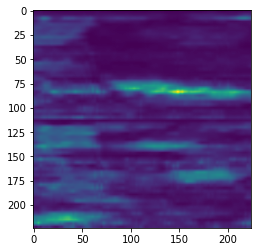

In [28]:
plt.imshow(train_pic_data[4,0,:,:])

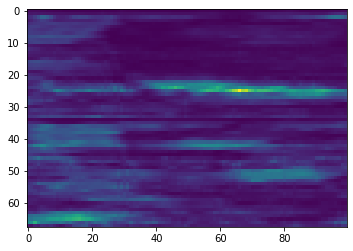

In [29]:
plt.imshow(train_pic_data_1[4,:,:])

## vgg模型

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,TensorDataset
from torchvision.models import vgg16
import d2lzh_pytorch as d2l

D:\ANACONDA\envs\ML_py38_CU\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\ANACONDA\envs\ML_py38_CU\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [31]:

batch_size = 128

#创建dataloader

data_train_tor = torch.from_numpy(train_pic_data)
data_train_tor = data_train_tor.float()
print(data_train_tor.size())


data_test_tor = torch.from_numpy(test_pic_data)
data_test_tor = data_test_tor.float()
print(data_test_tor.size())


label_train_tor = torch.from_numpy(train_label)
label_train_tor = label_train_tor.float()
label_test_tor = torch.from_numpy(test_label)
label_test_tor = label_test_tor.float()

#改成四维张量   样本数 * 通道数 * 高 * 宽 
#data_train_tor = data_train_tor.reshape(train_pic_data.shape[0],1,train_pic_data.shape[2],train_pic_data.shape[3])
print(data_train_tor.size())


#data_test_tor = data_test_tor.reshape(test_pic_data.shape[0],1,test_pic_data.shape[2],test_pic_data.shape[3])
print(data_test_tor.size())




train_dataset = TensorDataset(data_train_tor,label_train_tor)
test_dataset = TensorDataset(data_test_tor,label_test_tor)


train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

torch.Size([4000, 1, 224, 224])
torch.Size([3200, 1, 224, 224])
torch.Size([4000, 1, 224, 224])
torch.Size([3200, 1, 224, 224])


In [32]:
def vgg_block(num_convs,in_channels,out_channels):
    blk = []
    for i in range(num_convs):
        if i ==0:
            blk.append(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1))
        else:
            blk.append(nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*blk)

#经过5个VGG_block  ，宽和高减半5次 ，变成224/32 = 7
conv_arch = ((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
fc_features = 512*7*7 
fc_hidden_units = 4096

def vgg(conv_arch,fc_features,fc_hidden_units=4096):
    net = nn.Sequential()

    #卷积部分
    for i,(num_convs,in_channels,out_channels) in enumerate(conv_arch):
        net.add_module('vgg_block_'+str(i+1),vgg_block(num_convs,in_channels,out_channels))

    net.add_module('fc',nn.Sequential(d2l.FlattenLayer(),
                                    nn.Linear(fc_features,fc_hidden_units),
                                    nn.ReLU(),
                                    nn.Dropout(0.5),
                                    nn.Linear(fc_hidden_units,fc_hidden_units),
                                    nn.ReLU(),
                                    nn.Dropout(0.5),
                                    nn.Linear(fc_hidden_units,2)
                                    ))
    return net

net = vgg(conv_arch=conv_arch,fc_features=fc_features,fc_hidden_units=fc_hidden_units)

In [33]:

X = torch.rand(1,1,224,224)
print(net)
for name,blk in net.named_children():
    X = blk(X)
    print(name,'  output shape :',X.shape)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [34]:
ratio = 8

small_conv_arch = ((1,1,64//ratio),(1,64//ratio,128//ratio),(2,128//ratio,256//ratio),
                    (2,256//ratio,512//ratio),(2,512//ratio,512//ratio))

net = vgg(small_conv_arch, fc_features//ratio , fc_hidden_units//ratio)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda


In [36]:
def evaluate_accuracy_gpu(net,test_dataloader,
                        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """使用GPU计算模型再数据集上面的精度"""
    acc_sum , n = 0.0,0
    with torch.no_grad():
        for i,data in enumerate(test_dataloader):
            X = data[0]
            y = data[1]


            net.eval() #评估模式
            acc_sum += (net(X.to(device)).argmax(dim=1) == 
            y.to(device)).float().sum().cpu().item()
            net.train() #改回训练模式

            
            '''
            if  isinstance(net,torch.nn.Module):
                net.eval() #评估模式
                acc_sum += (net(X.to(device)).argmax(dim=1) == 
                            y.to(device)).float().sum().cpu().item()
                net.train() #改回训练模式
            else: #自定义模型  3.13节之后不会用到,不考虑GPU
                if( 'is_training ' in net.__code__.co_varnames ):
                    #如果有is_training这个参数
                    #将is_training设置维False
                    acc_sum += (net(X,is_training=False).argmax(dim=1) == y).float.sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
            '''
            #y.shape[0]为一个batch的样本数
            n += y.shape[0]
    return acc_sum/n

In [37]:
import time
def train_CNN(net,train_dataloader,valid_dataloader,batch_size,optimizer,device,num_epochs):
    net = net.to(device)
    print('training on',device)

    loss = torch.nn.CrossEntropyLoss()
    batch_count = 0
    
   
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum ,n,start = 0.0,0.0,0,time.time()
        all_miss_count = 0
        for i,data in enumerate(train_dataloader):
            print('data shape :',data.shape)
            X = data[0]
            y = data[1]
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            
            l = loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            train_l_sum += l.cpu()
            train_acc_sum += (y_hat.argmax(dim=1) == y.argmax(dim=1)).sum().cpu()
            n += y.shape[0]
            batch_count += 1
            all_miss_count += (y_hat.argmax(dim=1) == y.argmax(dim=1)).sum().cpu()

        valid_acc = evaluate_accuracy_gpu(net,valid_dataloader,device)
        print('epoch %d , loss %.4f, train acc %.3f, valid acc %.3f, time %.1f sec ' % 
                (epoch+1 , train_l_sum/batch_count ,  train_acc_sum/n , 
                valid_acc,time.time()-start))

In [38]:
for i,data in enumerate(train_loader):
    X = data[0]
    print(X.shape)
    y = data[1]
    xxx = X.numpy()
    if i == 0:
        #plt.imshow(xxx[0,:,:])
        print('y size :',y.shape)
        y_hat = net(X)
        print('y_hat size : ',y_hat.shape)

torch.Size([128, 1, 224, 224])
y size : torch.Size([128, 2])
y_hat size :  torch.Size([128, 2])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch.Size([128, 1, 224, 224])
torch

In [39]:
'''
lr , num_epochs = 0.0001 , 500


optimizer = torch.optim.Adam(net.parameters(),lr=lr)

start_time = time.time()

train_CNN(net,train_dataloader=train_loader,valid_dataloader=test_loader,batch_size=batch_size,optimizer=optimizer,
            device = device,num_epochs = num_epochs)
end_time = time.time()
used_time = end_time - start_time
print('训练的总时间为： %.1f sec' %(used_time))
'''

"\nlr , num_epochs = 0.0001 , 500\n\n\noptimizer = torch.optim.Adam(net.parameters(),lr=lr)\n\nstart_time = time.time()\n\ntrain_CNN(net,train_dataloader=train_loader,valid_dataloader=test_loader,batch_size=batch_size,optimizer=optimizer,\n            device = device,num_epochs = num_epochs)\nend_time = time.time()\nused_time = end_time - start_time\nprint('训练的总时间为： %.1f sec' %(used_time))\n"

In [40]:

lr,num_epochs = 0.0001,20
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
d2l.train_ch5(net,train_loader,test_loader,batch_size,optimizer,device,num_epochs)

training on cuda
epoch 1 , loss 0.6934, train acc 0.483, test acc 0.505, time 11.7 sec
epoch 2 , loss 0.3453, train acc 0.509, test acc 0.540, time 9.0 sec
epoch 3 , loss 0.2269, train acc 0.548, test acc 0.540, time 9.1 sec
epoch 4 , loss 0.1675, train acc 0.561, test acc 0.526, time 9.0 sec
epoch 5 , loss 0.1276, train acc 0.621, test acc 0.510, time 9.1 sec
epoch 6 , loss 0.1001, train acc 0.641, test acc 0.512, time 9.1 sec
epoch 7 , loss 0.0761, train acc 0.701, test acc 0.512, time 9.2 sec
epoch 8 , loss 0.0547, train acc 0.780, test acc 0.494, time 9.1 sec
epoch 9 , loss 0.0374, train acc 0.842, test acc 0.515, time 9.2 sec
epoch 10 , loss 0.0259, train acc 0.895, test acc 0.516, time 9.3 sec
epoch 11 , loss 0.0190, train acc 0.920, test acc 0.517, time 9.5 sec
epoch 12 , loss 0.0116, train acc 0.947, test acc 0.511, time 9.8 sec


KeyboardInterrupt: 